In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import scipy.stats as stat
import empiricaldist as ed

## Snow problem

In [36]:
df= pd.read_csv('snow_data.csv', parse_dates=[2])
df.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00190736,"BLUE HILL COOP, MA US",1967-05-14,0.00,0.0,0.0,67,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00190736,"BLUE HILL COOP, MA US",1967-05-15,0.31,0.0,0.0,49,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['YEAR'] = df['DATE'].dt.year
snow = df.groupby('YEAR')['SNOW'].sum()
# fisrt and last years not complete
snow = snow.iloc[1:-1]
len(snow)

52

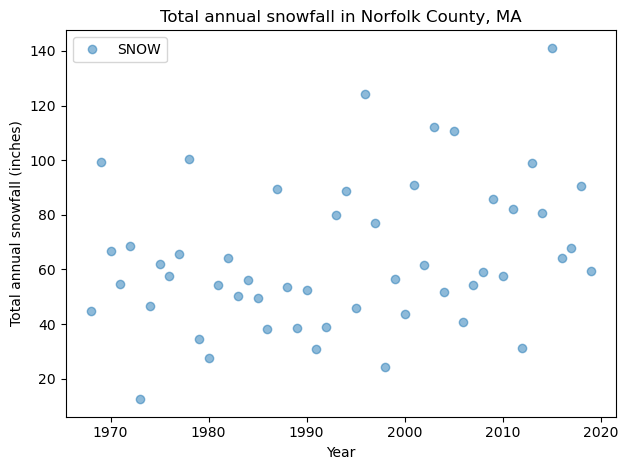

In [6]:

snow.plot(ls='', marker='o', alpha=0.5)

u.decorate(xlabel='Year',
         ylabel='Total annual snowfall (inches)',
         title='Total annual snowfall in Norfolk County, MA')

Looking at this plot, it’s hard to say whether snowfall is increasing, decreasing, or unchanged. In the last decade, we’ve had several years with more snow than 1978, including 2015, which was the snowiest winter in the Boston area in modern history, with a total of 141 inches.

This kind of question – looking at noisy data and wondering whether it is going up or down – is precisely the question we can answer with Bayesian regression.

### Regression Model

The foundation of regression (Bayesian or not) is the assumption that a time series like this is the sum of two parts:

A linear function of time, and

A series of random values drawn from a distribution that is not changing over time.

Mathematically, the regression model is: y = ax + b + sigma
where y is the series of measurements (snowfall in this example), x is the series of times (years) and sigma is the series of random values.

a and b are the slope and intercept of the line through the data. They are unknown parameters, so we will use the data to estimate them.

We don’t know the distribution of sigma, so we’ll make the additional assumption that it is a normal distribution with mean 0 and unknown standard deviation, .
To see whether this assumption is reasonable, I’ll plot the distribution of total snowfall and a normal model with the same mean and standard deviation.

64.19038461538462 26.28802198439569


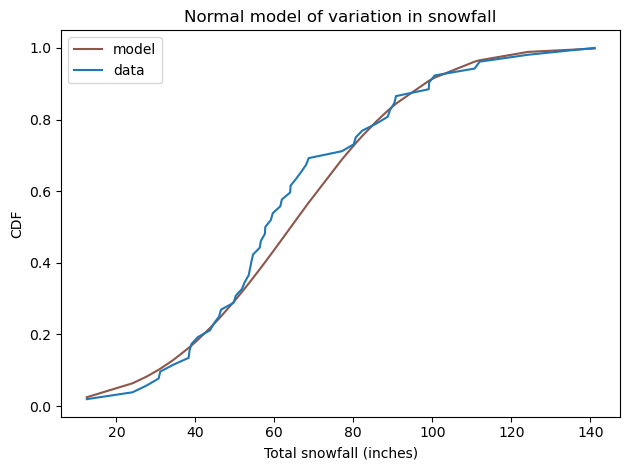

In [7]:
pmf_snowfall = ed.Pmf.from_seq(snow)

mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
print(mean, std)

dist = stat.norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)


plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')

u.decorate(xlabel='Total snowfall (inches)',
         ylabel='CDF',
         title='Normal model of variation in snowfall')

We’ve had more winters below the mean than expected, but overall this looks like a reasonable model.

### LS Regression

In [20]:
# center data by substracting the mean
data = pd.DataFrame(snow)
offset = round(np.mean(data.index))
data['x'] = data.index - offset
data['y'] = data['SNOW'].copy()
offset

1994

In [21]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    64.446325
x             0.511880
dtype: float64

In [22]:
results.resid.std()

25.385680731210627

The intercept, about 64 inches, is the expected snowfall when x=0, which is the beginning of 1994. The estimated slope indicates that total snowfall is increasing at a rate of about 0.5 inches per year.

results also provides resid, which is an array of residuals, that is, the differences between the data and the fitted line. The standard deviation of the residuals is an estimate of sigma.

### Prior

I made the prior distributions different lengths for two reasons. First, if we make a mistake and use the wrong distribution, it will be easier to catch the error if they are all different lengths.

Second, it provides more precision for the most important parameter, slope, and spends less computational effort on the least important, sigma.

A joint distribution with three parameters is  wrapped in a function:

In [23]:
prior_slope = u.make_uniform(np.linspace(-0.5, 1.5, 51), 'Slope')

prior_inter = u.make_uniform(np.linspace(54, 75, 41), 'Intercept')

prior_sigma = u.make_uniform(np.linspace(20, 35, 31), 'Sigma')

In [22]:
def make_joint_n(*args):
    """Make a joint distribution with 2+ parameters.
    args: pmf distributions
    """

    joint = u.make_joint(args[0], args[1]).stack()
    for pmf in args[2:]:
        joint = u.make_joint(pmf, joint).stack()
    return ed.Pmf(joint)

In [28]:
prior = make_joint_n(prior_slope, prior_inter, prior_sigma)
prior.head(3)

Intercept  Slope  Sigma
54.0       -0.5   20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
Name: , dtype: float64

In [83]:
xs = data['x']
ys = data['y']

# vektorized version of commented code
intercept, slope, sigma = np.array(list(prior.index)).T # unstack to arrays
slope_mesh, data_mesh = np.meshgrid(slope, xs)

pred = slope_mesh * data_mesh + intercept
resid = ys.values.reshape(-1, 1) - pred

densities = stat.norm.pdf(
    resid, 0, sigma
)

posterior = prior * densities.prod(axis=0)
posterior.normalize()

# likelihood = prior.copy()

# for slope, inter, sigma in prior.index:
#     expected = slope * xs + inter
#     resid = ys - expected
#     densities = norm.pdf(resid, 0, sigma)
#     likelihood[slope, inter, sigma] = densities.prod()

6.769832641515687e-107

In [87]:
posterior_slope = posterior.marginal(1)
posterior_inter = posterior.marginal(0)
posterior_sigma = posterior.marginal(2)

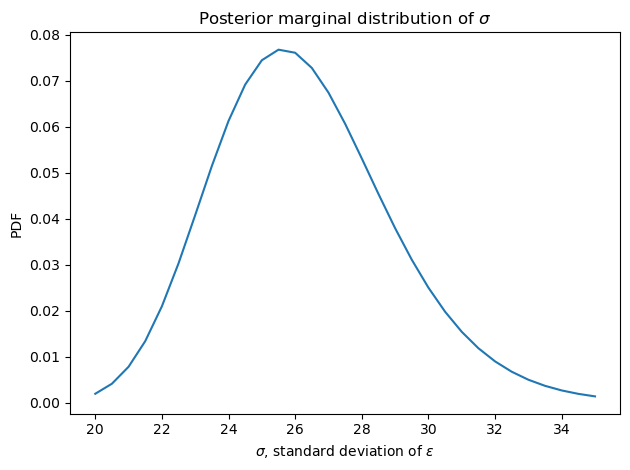

In [88]:
posterior_sigma.plot()

u.decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

The most likely values for sigma are near 26 inches, which is consistent with our estimate based on the standard deviation of the data.

However, to say whether snowfall is increasing or decreasing, we don’t really care about sigma. It is a “nuisance parameter”, so-called because we have to estimate it as part of the model, but we don’t need it to answer the questions we are interested in.

Nevertheless, it is good to check the marginal distributions to make sure

The location is consistent with our expectations, and

The posterior probabilities are near 0 at the extremes of the range, which indicates that the prior distribution covers all parameters with non-negligible probability.

In this example, the posterior distribution of sigma looks fine.

(64.5, 64.44820250931717)

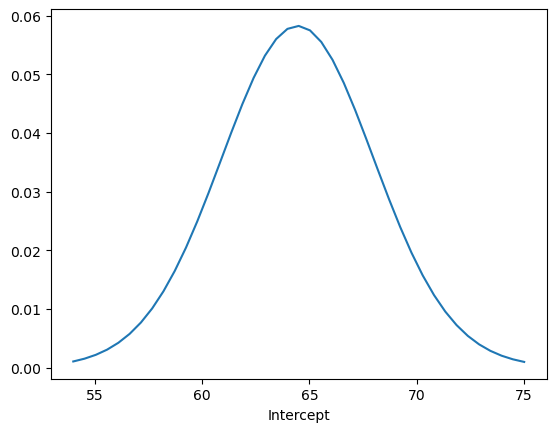

In [97]:
posterior_inter.plot()
posterior_inter.max_prob(), posterior_inter.mean()

(0.5, 0.5118702152608383)

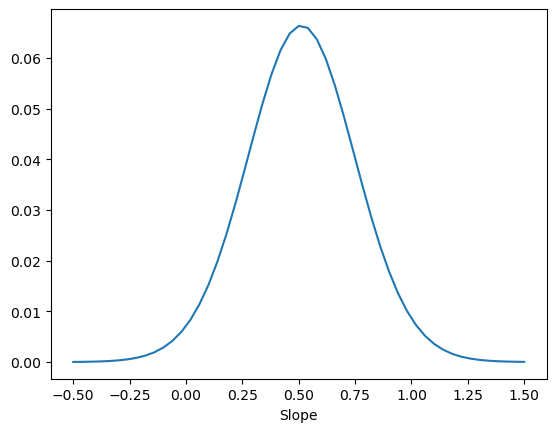

In [96]:
posterior_slope.plot()
posterior_slope.max_prob(), posterior_slope.mean()

In [95]:
u.summarize(posterior_slope)

0.512 [0.1 0.9]


In [98]:
posterior_slope.make_cdf()(0)

array(0.01840519)

The posterior mean is about 0.51 inches, which is consistent with the estimate we got from least squared regression.

The 90% credible interval is from 0.1 to 0.9, which indicates that our uncertainty about this estimate is pretty high. In fact, there is still a small posterior probability (about 2%) that the slope is negative.

However, it is more likely that my conjecture was wrong: we are actually getting more snow around here than we used to, increasing at a rate of about a half-inch per year, which is substantial. On average, we get an additional 25 inches of snow per year than we did when I was young.

This example shows that with slow-moving trends and noisy data, your instincts can be misleading.

Now, you might suspect that I overestimate the amount of snow when I was young because I enjoyed it, and underestimate it now because I don’t. But you would be mistaken.

## Marathon

For many running events, if you plot the world record pace over time, the result is a remarkably straight line. People, including me, have speculated about possible reasons for this phenomenon.

People have also speculated about when, if ever, the world record time for the marathon will be less than two hours. (Note: In 2019 Eliud Kipchoge ran the marathon distance in under two hours, which is an astonishing achievement that I fully appreciate, but for several reasons it did not count as a world record).

So, as a second example of Bayesian regression, we’ll consider the world record progression for the marathon (for male runners), estimate the parameters of a linear model, and use the model to predict when a runner will break the two-hour barrier.

In [4]:
# url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
# tables = pd.read_html(url)
# len(tables)

# table = tables[0]
# table.to_csv('marathon.csv')

In [13]:
table = pd.read_csv('marathon.csv')
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['time'] = pd.to_timedelta(table['Time'])

# convert time to pace miles per hour
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
table.tail(3)

,Unnamed: 0,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
48,48,2:02:57,Dennis Kimetto,Kenya,"September 28, 2014",Berlin Marathon,IAAF[85][86] ARRS[82],The ARRS notes Kimetto's extended time as 2:02...,2014-09-28,0 days 02:02:57,12.785685
49,49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[1],NaN,2018-09-16,0 days 02:01:39,12.922318
50,50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,IAAF[87],NaN,2022-09-25,0 days 02:01:09,12.975650


In [14]:
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

In [15]:
def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(13.1, color='C5', ls='--')
    plt.plot(df['date'], df['y'], 'o', 
             label='World record speed', 
             color='C1', alpha=0.5)
    
    u.decorate(xlabel='Date',
             ylabel='Speed (mph)')

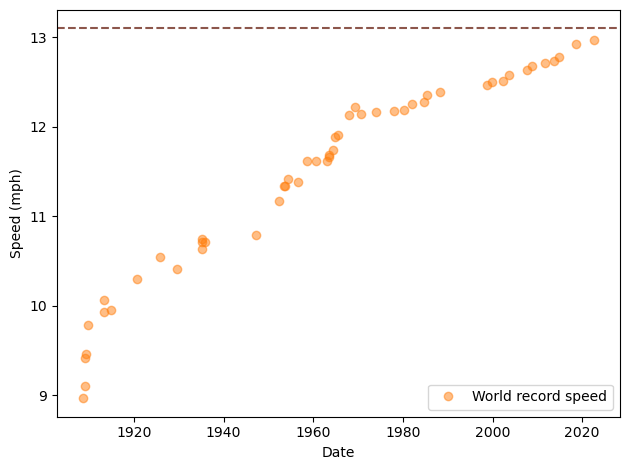

In [16]:
plot_speeds(table)

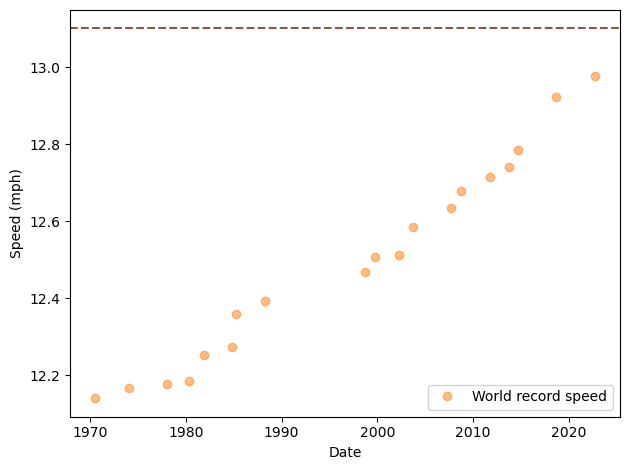

In [17]:
data = table[table['date'].dt.year>=1970]
plot_speeds(data)

In [18]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset

data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data.x.describe()

/tmp/ipykernel_24514/3692619941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24


count    19.000000
mean      2.161520
std      16.212660
min     -24.444201
25%     -11.633447
50%       4.810536
75%      15.236557
max      27.732450
Name: x, dtype: float64

In [19]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    12.464040
x             0.015931
dtype: float64

In [20]:
results.resid.std()

0.04419653543387638

In [23]:
prior_slope = u.make_uniform(np.linspace(0.012, 0.018, 51), 'Slope')

prior_inter = u.make_uniform(np.linspace(12.4, 12.5, 41), 'Intercept')

prior_sigma = u.make_uniform(np.linspace(0.01, 0.21, 31), 'Sigma')

prior = make_joint_n(prior_slope, prior_inter, prior_sigma)
prior.head()

Intercept  Slope  Sigma   
12.4       0.012  0.010000    0.000015
                  0.016667    0.000015
                  0.023333    0.000015
Name: , dtype: float64

In [24]:
xs = data['x']
ys = data['y']

intercept, slope, sigma = np.array(list(prior.index)).T # unstack to arrays
slope_mesh, data_mesh = np.meshgrid(slope, xs)

pred = slope_mesh * data_mesh + intercept
resid = ys.values.reshape(-1, 1) - pred

densities = stat.norm.pdf(
    resid, 0, sigma
)

posterior = prior * densities.prod(axis=0)
posterior.normalize()

1161389020603.8816

In [25]:
posterior_slope = posterior.marginal(1)
posterior_inter = posterior.marginal(0)
posterior_sigma = posterior.marginal(2)

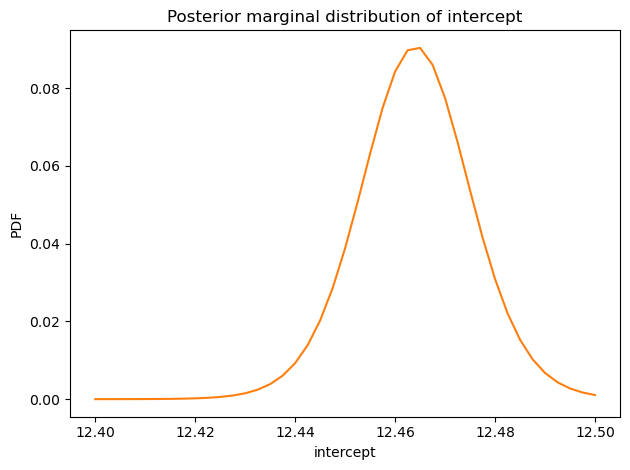

In [26]:
posterior_inter.plot(color='C1')
u.decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

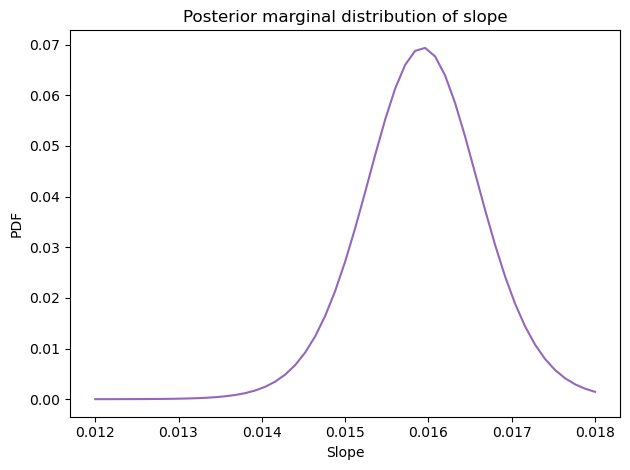

In [27]:
posterior_slope.plot(color='C4')
u.decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

The posterior mean is about 12.5 mph, which is the world record marathon pace the model predicts for the midpoint of the date range, 1994.

The posterior mean is about 0.015 mph per year, or 0.15 mph per decade.

### Prediction

Each prediction is an array with the same length as xs, which I store as a row in pred. So the result has one row for each sample and one column for each value of x.

We can use percentile to compute the 5th, 50th, and 95th percentiles in each column.

In [31]:
sample = posterior.choice(101) # sample of parameters

xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (inter, slope, sigma) in enumerate(sample):
    epsilon = stat.norm(0, sigma).rvs(len(xs))
    pred[i] = inter + slope * xs + epsilon

In [32]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

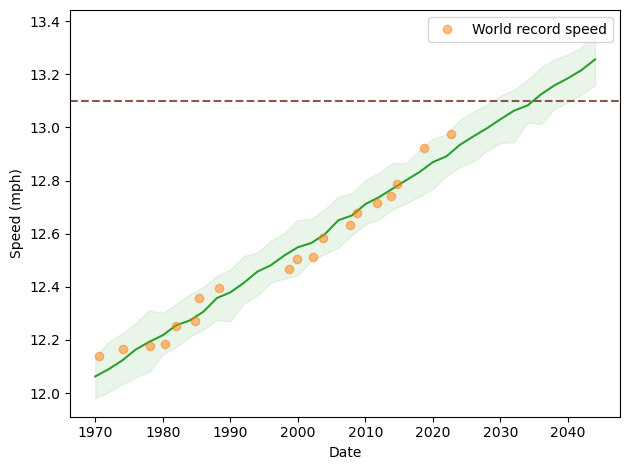

In [33]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, 
                 color='C2', alpha=0.1)
plt.plot(times, median, color='C2')

plot_speeds(data)

The dashed line shows the two-hour marathon pace, which is 13.1 miles per hour. Visually we can estimate that the prediction line hits the target pace between 2030 and 2040.

To make this more precise, we can use interpolation to see when the predictions cross the finish line. SciPy provides interp1d, which does linear interpolation by default.

In [34]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

In [35]:
dts = pd.to_timedelta(future*365.24, unit='day') + offset
pd.DataFrame(dict(datetime=dts),
             index=['early', 'median', 'late'])

,datetime
early,2028-11-10 11:17:08.304518400
median,2034-11-03 03:56:41.020569600
late,2040-05-09 09:23:58.247664000


## Exercises

### 1

I am under the impression that it is warmer around here than it used to be. In this exercise, you can put my conjecture to the test.

We’ll use the same dataset we used to model snowfall; it also includes daily low and high temperatures in Norfolk County, Massachusetts during my lifetime.

In [48]:
df= pd.read_csv('snow_data.csv', parse_dates=[2])
df.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00190736,"BLUE HILL COOP, MA US",1967-05-14,0.00,0.0,0.0,67,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00190736,"BLUE HILL COOP, MA US",1967-05-15,0.31,0.0,0.0,49,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df['year'] = df['DATE'].dt.year
df['TMID'] = (df['TMIN'] + df['TMAX']) / 2

grouped = df.groupby('year')['TMID'].mean().iloc[1:-1]
grouped.head()

year
1968    48.071038
1969    48.687671
1970    48.258904
1971    48.804110
1972    47.112022
Name: TMID, dtype: float64

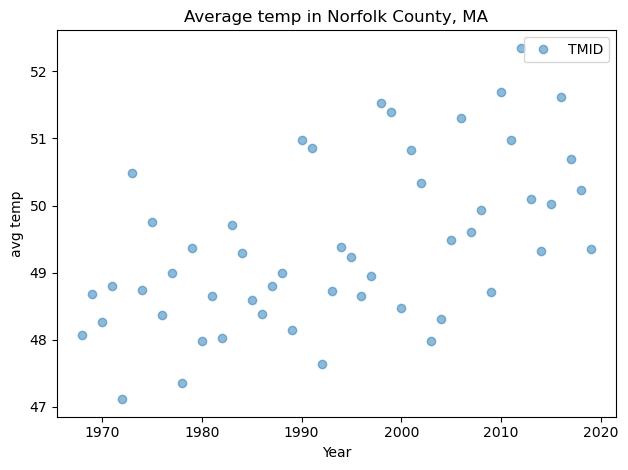

In [52]:
grouped.plot(ls='', marker='o', alpha=0.5)

u.decorate(xlabel='Year',
         ylabel='avg temp',
         title='Average temp in Norfolk County, MA')

49.408046214993256 1.226940961773094


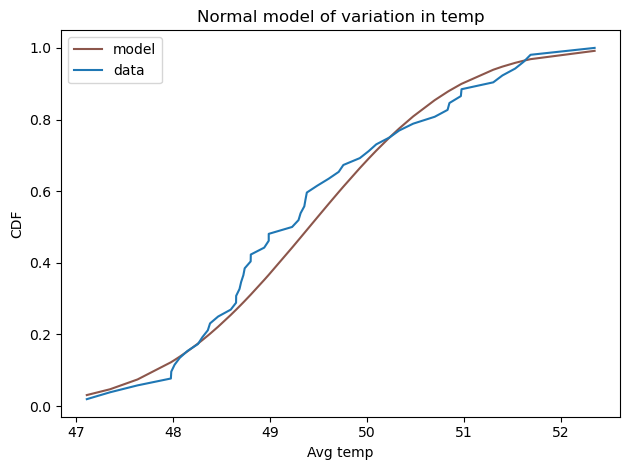

In [56]:
pmf_temp = ed.Pmf.from_seq(grouped)

mean, std = pmf_temp.mean(), pmf_temp.std()
print(mean, std)

dist = stat.norm(mean, std)
qs = pmf_temp.qs
ps = dist.cdf(qs)


plt.plot(qs, ps, color='C5', label='model')
pmf_temp.make_cdf().plot(label='data')

u.decorate(xlabel='Avg temp',
         ylabel='CDF',
         title='Normal model of variation in temp')

In [57]:
data = pd.DataFrame(grouped).reset_index()
data.head()

,year,TMID
0,1968,48.071038
1,1969,48.687671
2,1970,48.258904
3,1971,48.804110
4,1972,47.112022


In [58]:
mean_year = round(data['year'].mean())
data['x'] = data['year'] - mean_year
data['y'] = data['TMID'].copy()
data.head()

,year,TMID,x,y
0,1968,48.071038,-26,48.071038
1,1969,48.687671,-25,48.687671
2,1970,48.258904,-24,48.258904
3,1971,48.804110,-23,48.804110
4,1972,47.112022,-22,47.112022


In [59]:
results = smf.ols('y ~ x', data=data).fit()
results.params

Intercept    49.430172
x             0.044252
dtype: float64

In [60]:
data[data['year']==mean_year]

,year,TMID,x,y
26,1994,49.382192,0,49.382192


In [61]:
results.resid.std()

1.0417057653902053

In [81]:
prior = make_joint_n(
    u.make_uniform(np.linspace(48, 51, 51), 'Intercept'),
    u.make_uniform(np.linspace(0.01, 0.08, 100), 'Slope'),
    u.make_uniform(np.linspace(0.5, 1.8, 30), 'Sigma')
)

In [82]:
prior.head()

Slope  Intercept  Sigma   
0.01   48.0       0.500000    0.000007
                  0.544828    0.000007
                  0.589655    0.000007
Name: , dtype: float64

In [83]:
len(prior)

153000

In [84]:
xs = data['x'].values
ys = data['y'].values


slope, intercept, sigma = np.array(list(prior.index)).T # unstack to arrays
slope_mesh, data_mesh = np.meshgrid(slope, xs)

pred = slope_mesh * data_mesh + intercept
resid = ys.reshape(-1, 1) - pred

densities = stat.norm.pdf(
    resid, 0, sigma
)

posterior = prior * densities.prod(axis=0)
posterior.normalize()

1.4406263766599848e-35

In [85]:
posterior.head(1)

,,,probs
Slope,Intercept,Sigma,
0.01,48.0,0.5,2.329391e-126


In [86]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

1.079 [0.90344828 1.26206897]


<AxesSubplot:xlabel='Sigma'>

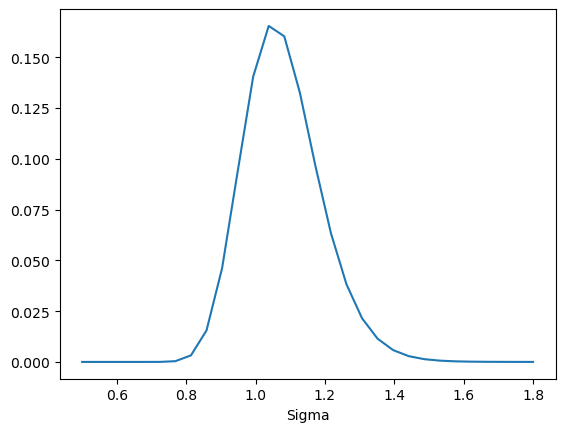

In [87]:
u.summarize(posterior_sigma)
posterior_sigma.plot()

0.044 [0.02767677 0.06090909]
None [0.01848485 0.07010101]


<AxesSubplot:xlabel='Slope'>

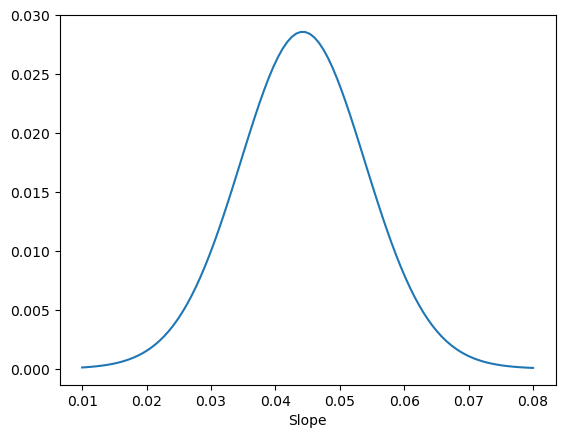

In [93]:
print(u.summarize(posterior_slope), posterior_slope.credible_interval(0.99))
posterior_slope.plot()

49.43 [49.2  49.68]


<AxesSubplot:xlabel='Intercept'>

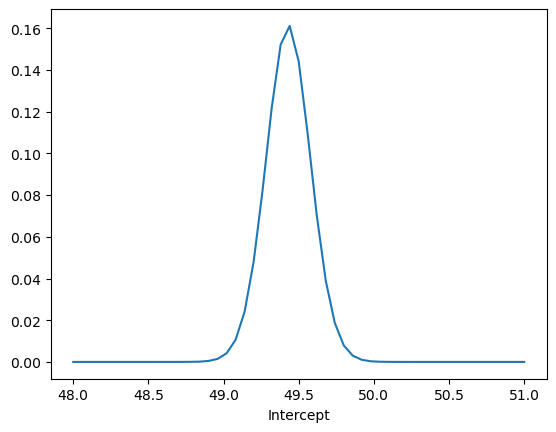

In [89]:

u.summarize(posterior_inter)
posterior_inter.plot()

In [97]:
sample = posterior.choice(200)
xs = np.arange(
    data['year'].min(),
    2068
)

predictions = np.empty((len(sample),len(xs)))

print(predictions.shape, xs.min(), xs.max())

xs = xs - mean_year

(200, 100) 1968 2067


In [99]:
for i, (b1, b0, e) in enumerate(sample):
    pred = b0 + b1*xs + stat.norm(0, e).rvs(xs.shape)
    predictions[i] = pred

In [140]:
low, median, high = np.percentile(predictions, [5, 50, 95], axis=0)

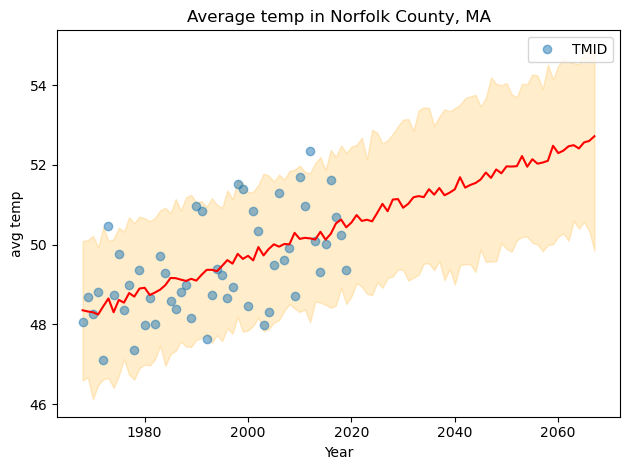

In [141]:
grouped.plot(ls='', marker='o', alpha=0.5)

plt.plot(xs+mean_year, median, color='red')

plt.fill_between(
    xs+mean_year, low, high, alpha=0.2, color='orange'
)

u.decorate(xlabel='Year',
         ylabel='avg temp',
         title='Average temp in Norfolk County, MA')

In [142]:
median[-1] - median[0]

4.3638021923887464

In [143]:
low[-1] - median[0]

1.49369933466388

In [144]:
high[-1] - median[0]

6.398584232222284

In [146]:
i = 2050 - df['year'].min()
low[i] - np.mean(median[0:5]), median[i] - np.mean(median[0:5]), high[i] - np.mean(median[0:5])

(1.485432905158575, 3.621045779884277, 5.430279705286665)

In [110]:
len(median)

100

In [127]:
df['year'].min()+i

2021

In [216]:
d = {
    'year': [1900, 1950, 2018],
    'urban (M)': [70, 110, 150], 
    'crops (B)': [0.844, 1.2, 1.6],
    'grazing (B)': [1.7, 3.3, 3.2],
    'forest (B)': [5.1, 4.7, 4.0],
    'grassland (B)': [3.0, 1.4, 1.7]
}
df = pd.DataFrame(d)
df = df.set_index('year',drop=True)

In [217]:
from sklearn.linear_model import LinearRegression

In [219]:
reg = LinearRegression().fit((df.index-np.mean(df.index)).values.reshape(-1, 1), df['urban (M)'])
min_ = 1900
max_ = 2018

x = np.array(range(min_, max_+1))-np.mean(df.index)

In [221]:
x*reg.coef_ + reg.intercept_

array([ 72.32611174,  72.99885975,  73.67160775,  74.34435576,
        75.01710376,  75.68985177,  76.36259977,  77.03534778,
        77.70809578,  78.38084379,  79.05359179,  79.72633979,
        80.3990878 ,  81.0718358 ,  81.74458381,  82.41733181,
        83.09007982,  83.76282782,  84.43557583,  85.10832383,
        85.78107184,  86.45381984,  87.12656784,  87.79931585,
        88.47206385,  89.14481186,  89.81755986,  90.49030787,
        91.16305587,  91.83580388,  92.50855188,  93.18129989,
        93.85404789,  94.5267959 ,  95.1995439 ,  95.8722919 ,
        96.54503991,  97.21778791,  97.89053592,  98.56328392,
        99.23603193,  99.90877993, 100.58152794, 101.25427594,
       101.92702395, 102.59977195, 103.27251995, 103.94526796,
       104.61801596, 105.29076397, 105.96351197, 106.63625998,
       107.30900798, 107.98175599, 108.65450399, 109.327252  ,
       110.        , 110.672748  , 111.34549601, 112.01824401,
       112.69099202, 113.36374002, 114.03648803, 114.70

In [232]:
def plot(column):
    min_ = 1900
    max_ = 2018
    
    x = np.array(range(min_, max_+20))
    x_pred = x-min_
    x_fit = df.index-min_
    X = np.array([x_fit]).reshape(-1, 1) # x_fit**2
    print(len(x), max(x), X.shape)
    reg = LinearRegression()
    reg.fit(X, df[column])
    y = reg.intercept_ + reg.coef_[0]*x_pred #+ reg.coef_[1]*x_pred**2

    plt.plot(x, y, label=column)
    # plt.xticks(list(range(0, len(x))), x)
    plt.legend()
    plt.show()
    plt.close()

138 2037 (3, 1)


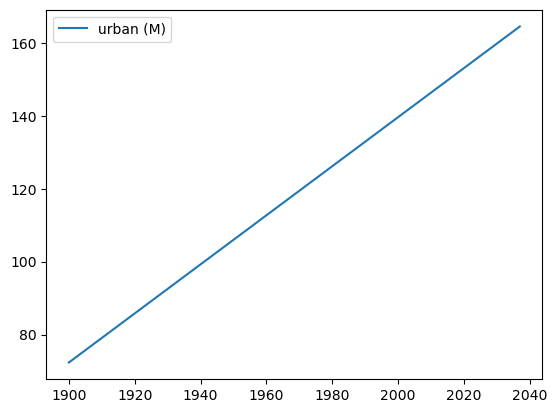

138 2037 (3, 1)


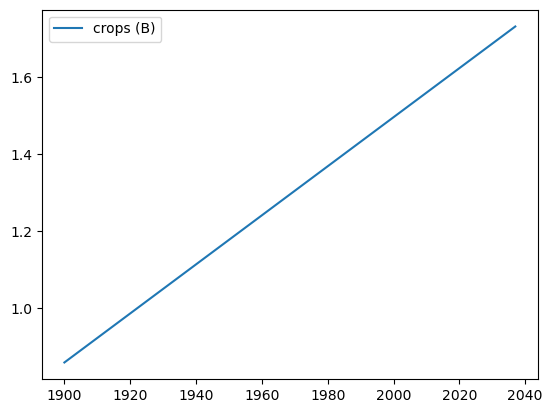

138 2037 (3, 1)


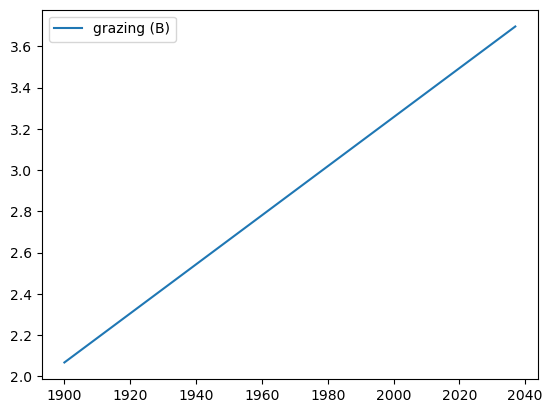

138 2037 (3, 1)


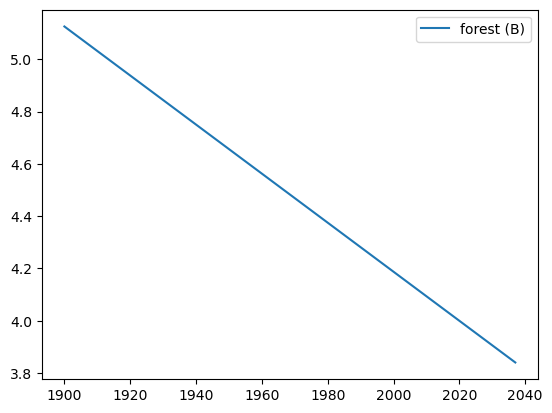

138 2037 (3, 1)


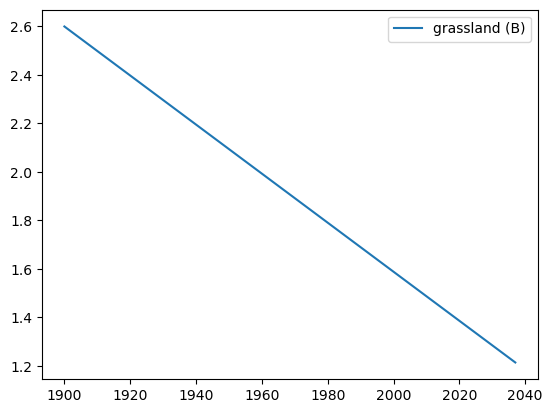

In [233]:
for c in df.columns:
    plot(c)